In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

# Pytorch Workflow

1) Preparación de datos
2) Construcción del modelo
3) Ajuste del modelo a los datos (entrenamiento)
4) Hacer predicciones y evaluar el modelo (inferencia)
5) Guardar y cargar modelo

## Preparación de datos

Transformamos los datos en representaciones numéricas para luego construir un modelo que aprenda patrones dentro de esa representación. 

Empezamos con datos "conocidos" usando regresión lineal.

### Regresión Lineal

In [2]:
weight = 0.7 #pendiente
bias = 0.3 #termino independiente

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)

y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

### Separación de datos para entrenamiento, validación y testeo

#### Entrenamiento

In [3]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

Visualization de datos:

In [4]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None, model_name = ""):
    """
    Plots training data, test data, and compares predictions

    Output:
        - Train data (color Blue)
        - Test data (color Green)
        - Predictions (color red)
    """
    plt.scatter(train_data, train_labels, c="b", s=4, label = "Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label = "Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.title(f"{model_name} Predictions") 

    plt.legend()

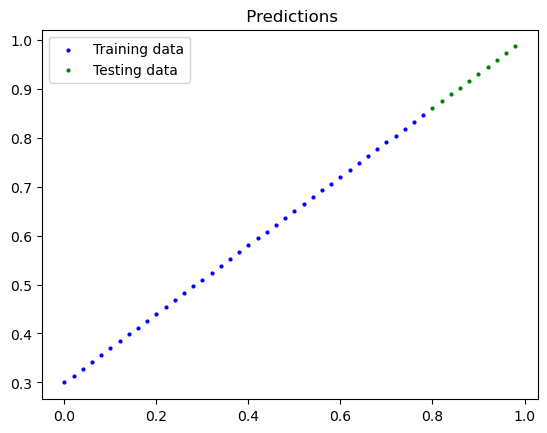

In [5]:
plot_predictions()

### Construimos el modelo

Se construye un modelo matemático:

\begin{equation}

Y_{i} = f(X_{i}, \beta) + e_{i}

\end{equation}
Donde:
-   $Y_{i}$ es la variable dependiente
-   $f$ es una función
-   $X_{i}$ es la variable independiente
-   $\beta$ son parámetros desconocidos
-   $e_{i}$ es el término del error

En este caso usamos una regresión lineal: $Y = a + bX$

#### Cómo funciona el modelo?

1) Arranca con valores aleatorios (weight y bias)
2) Mira los datos de entrenamiento y ajusta los valores random para obtener una mejor representación (o acercarse) de los valores ideales para crear esos datos.

Para eso usa dos algoritmos:
1) Gradient descent: El descenso de gradiente es un algoritmo de optimización que se utiliza para minimizar alguna función moviéndose iterativamente en la dirección del descenso más pronunciado definido por el negativo del gradiente. En el aprendizaje automático, utilizamos el descenso de gradiente para actualizar los parámetros de nuestro modelo. En este caso, los parámetros son weights (pendiente) y bias (termino independente).

2) Backpropagation: ...

Nosotros ejecutamos el codigo de alto nivel y Pytorch ejecuta el codigo de bajo nivel.

In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))


        #Forward method
    def forward(self, x: torch.Tensor) -> torch.Tensor: #x is input data
        return self.weights * x + self.bias #regresion lineal

## Pytorch model building essentials

- torch.nn: posee todas las construcciones para hacer una red neuronal
- torch.nn.Parameter: Representa los parámetros que el modelo tiene que aprender, a veces torch.nn los va a establecer por nosotros
- torch.nn.Module: la clase base para para todos los modulos de red neuronal. Si se hace una subclase, hay que sobreescribir el método forward()
- torch.optim: Optimizador para el descenso de gradiente.
- def forward(): Este método computa los datos

In [7]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Predicciones

Cuando le pasamos datos al modelo, este los va a correr con el método .forward().

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


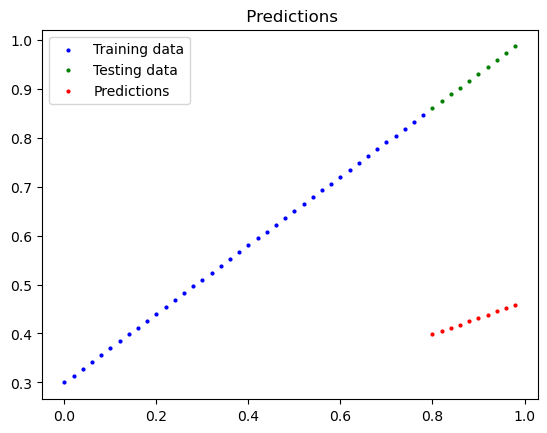

In [10]:
with torch.inference_mode():
    y_preds = model_0(X_test)

print(y_preds)
plot_predictions(predictions=y_preds)

### Entrenamiento del modelo

La forma de verificar que tan incorrecto son las predicciones se usan loss functions o cost functions.

Para el entrenamiento del modelo se necesitan la loss function, optimizador, training loop y testing loop

In [11]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [8]:
#loss function
loss_fn = nn.L1Loss()

#optimizador
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

Para el bucle de entrenamiento necesitamos:

1) Buclear a través de los datos
2) Usar el forward()
3) Calcular loss
4) Gradiente = 0: con cada iteración se estsblece al grafiente en 0
5) Loss backwards: retrocedemos a través de la red para calcular los gradientes de cada parámetro con respecto a la perdida (backpropagation)
6) Paso del optimizador: gradiant descent

In [9]:
#bucle de entrenamiento
torch.manual_seed(42)


epochs = 200   #el epoch es un loop a través de los datos

#track values
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):

    model_0.train()

    #forward pass
    y_pred = model_0(X_train)

    #calculate loss
    loss = loss_fn(y_pred, y_train)

    #optimizer zero grad
    optimizer.zero_grad()

    #backpropagation
    loss.backward()

    #step the optimizer
    optimizer.step()

    #testing
    model_0.eval()          #desactiva algunas configuraciones en el modelo que no necesitamos para testear
    
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 2 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 2 | Loss: 0.28983935713768005 | Test loss: 0.4541231691837311
Epoch: 4 | Loss: 0.26679736375808716 | Test loss: 0.4271811842918396
Epoch: 6 | Loss: 0.24375534057617188 | Test loss: 0.40023916959762573
Epoch: 8 | Loss: 0.22071333229541779 | Test loss: 0.37329721450805664
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 12 | Loss: 0.1746293306350708 | Test loss: 0.3194132149219513
Epoch: 14 | Loss: 0.1515873372554779 | Test loss: 0.2924712300300598
Epoch: 16 | Loss: 0.1285453587770462 | Test loss: 0.2655292749404907
Epoch: 18 | Loss: 0.1060912236571312 | Test loss: 0.2395961582660675
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 22 | Loss: 0.07638873159885406 | Test loss: 0.19773726165294647
Epoch: 24 | Loss: 0.06747635453939438 | Test loss: 0.18101617693901062
Epoch: 26 | Loss: 0.06097004935145378 | Test loss: 0.16665108501911163
Epoch: 28 | Loss: 0.056

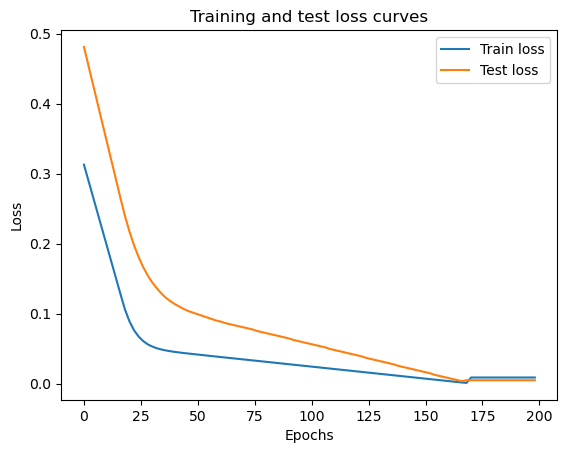

In [10]:
#plot the loss curves

plot_loss_values = map(lambda x: x.detach().numpy(), loss_values)
plot_test_loss_values = map(lambda x: x.detach().numpy(), test_loss_values)

plt.plot(epoch_count, list(plot_loss_values), label="Train loss")
plt.plot(epoch_count, list(plot_test_loss_values), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [22]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [11]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

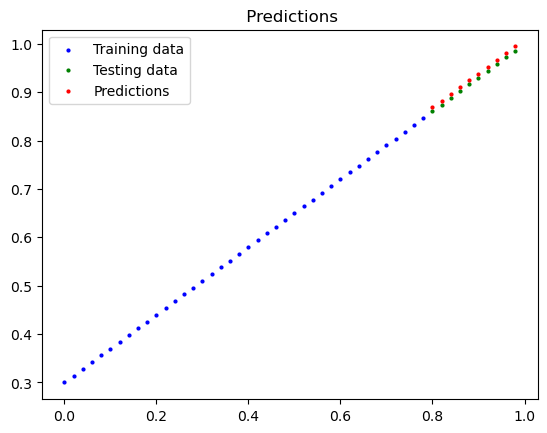

In [12]:
plot_predictions(predictions=y_preds_new)

### Guardar el modelo

3 métodos:
- torch.save(): guarda un objeto Pytorch en formato Python's pickle
- torch.load(): carga un objeto Pytorch
- torch.nn.Module.load_state_dict(): carga el state dict guardado de un modelo

In [13]:
from pathlib import Path

# 1) Crear el directorio
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2) Crear al path de guardado
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3) Guardar el model state dict
print(F"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


#### Cargar el modelo

Como estamos cargando el state dict del modelo en en lugar del modelo entero, debemos crear una nueva instancia del modelo y cargarle el state dict.

In [15]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [16]:
#comparamos modelos
loaded_model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
    loaded_model_preds = loaded_model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Repaso y juntando todos los pasos

Device-agnostic code: Se prepara para funcionar con GPU pero no si no hay GPU disponible el código trabaja con CPU

In [17]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [21]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None, model_name = ""):
    """
    Plots training data, test data, and compares predictions

    Output:
        - Train data (color Blue)
        - Test data (color Green)
        - Predictions (color red)
    """
    plt.scatter(train_data, train_labels, c="b", s=4, label = "Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label = "Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.title(f"{model_name} Predictions") 

    plt.legend()

### Datos

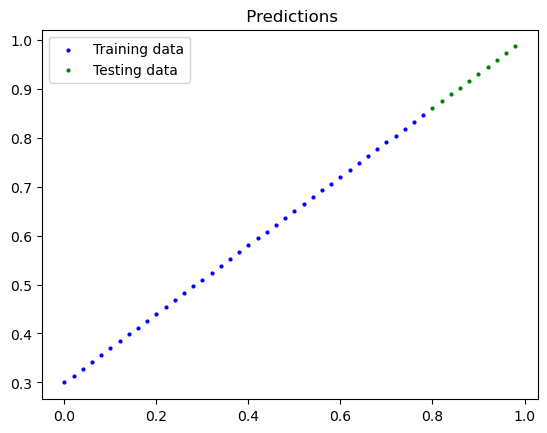

In [20]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

#split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

plot_predictions()

In [24]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        #usamos nn.Linear() para crear los parámetros del modelo. Es una transformación lineal
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.linear_layer(x)
    

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [25]:
#set the model to use device target

model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

### Entrenamiento

In [26]:
#setup loss function
loss_fn = nn.L1Loss()

#setup optimizer
optimizer = torch.optim.SGD(lr = 0.1, params=model_1.parameters())

#training loop

torch.manual_seed(42)

epochs = 200

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # 1) forward() pass
    y_pred = model_1(X_train)

    # 2) calular loss
    loss = loss_fn(y_pred, y_train)

    # 3) Optimizer zero grad
    optimizer.zero_grad()

    # 4) backpropagation
    loss.backward()

    # 5) Optimizer step
    optimizer.step()

    #Testing
    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10: 
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 1 | Loss: 0.43996793031692505 | Test loss: 0.31802722811698914
Epoch: 2 | Loss: 0.3247579038143158 | Test loss: 0.1833171844482422
Epoch: 3 | Loss: 0.20954790711402893 | Test loss: 0.048607222735881805
Epoch: 4 | Loss: 0.09433790296316147 | Test loss: 0.08610274642705917
Epoch: 5 | Loss: 0.030266335234045982 | Test loss: 0.01726674474775791
Epoch: 6 | Loss: 0.03247154876589775 | Test loss: 0.11862673610448837
Epoch: 7 | Loss: 0.05759608745574951 | Test loss: 0.016083210706710815
Epoch: 8 | Loss: 0.05761389806866646 | Test loss: 0.11862673610448837
Epoch: 9 | Loss: 0.05759608745574951 | Test loss: 0.016083210706710815
Epoch: 11 | Loss: 0.05759608745574951 | Test loss: 0.016083210706710815
Epoch: 12 | Loss: 0.05761389806866646 | Test loss: 0.11862673610448837
Epoch: 13 | Loss: 0.05759608745574951 | Test loss: 0.016083210706710815
Epoch: 14 | Loss: 0.05761389806866646 | Test loss: 0.11862673610448837
Epoch: 15 | Loss: 0.05759608745574951 | Test loss: 0.016083210706710815
Epoch: 16 

### Predicciones

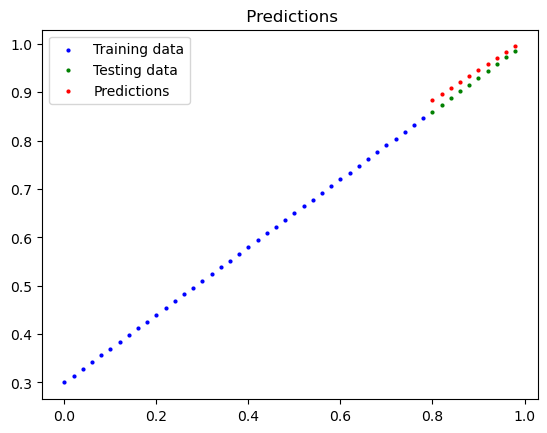

In [28]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

plot_predictions(predictions=y_preds)

### Guardar y cargar

In [29]:
from pathlib import Path

# 1) Crear el directorio
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2) Crear al path de guardado
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3) Guardar el model state dict
print(F"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth
